# Introduction
This notebook shows how to use Virtual Observatory (VO) services to find and retrieve images from the MAST archive.  Since these queries use VO protocols, they are not specific to MAST, and can be used to find and retrieve images from other VO data providers.  

### IVOA Protocols Used
* Table Access Protocol (TAP) - Allows SQL-like querying of databases.
* Simple Image Access Protocol (SIAP) - Allows searching for image products by sky region.

### Demonstrated Functionality
* Find MAST SIA services
 * Query the NAVO registry using TAP.
 * Display service metadata for use in selecting desired services.
* Search selected MAST services for images.
* Download and display the images.

### Assumptions
This notebook depends on the local python file **mastutils.py**.  That *mastutils* module contains convenience functions for performing the VO searches used in this notebook.  In particular, the functions **tap_query()** and **sia_query()** encapsulate the Table Access and Image Access requests.  

The functions in *mastutils* are not specific to MAST. They are applicable to VO services from all providers.

Browse the code here (TBD) for more details.

### Alternative MAST Data Access
#### Web Application
The MAST Discovery Portal (https://mast.stsci.edu) provides a powerful interactive interface for searching, filtering and downloading MAST data products.
#### Astroquery
Astroquery is a package affiliated with astropy which contains modules for accessing various archives.  The MAST Astroquery module is described here: http://astroquery.readthedocs.io/en/latest/mast/mast.html
#### MAST API
The MAST API defines a set of web services for accessing MAST.  These web services can be accessed from any language, including Python.  The MAST API is documented here:  https://mast.stsci.edu/api


# Imports
These are the modules needed for this notebook.

In [1]:
#
# Imports
#

import requests
import io
import numpy as np
from astropy.table import Table, unique
from astropy.utils.data import download_file
from astropy.io import fits

# Import convenience functions from local file mastutils.py
import mastutils

# For output using Markdown.
from IPython.display import Markdown, display

# There are a number of relatively unimportant warnings, so suppress them:
import warnings
warnings.filterwarnings("ignore")


# Find MAST Image Services
The MAST archive, located at the Space Telescope Science Institute (STScI), houses data from a number of optical, UV and near-IR missions.  

In order to find the VO services MAST offers for locating images, we will query the VO registry, a centralized database of all VO services from around the world.  We will use the VO's Table Access Protocol (TAP) to perform a database query on the registry.  For more details about searching the VO registry, see this notebook: TBD

In this case, our database query will look for Simple Image Access services hosted by MAST (STScI).

In [2]:
# Define the base URL for the NAVO registry.
tap_service_url = "https://vao.stsci.edu/RegTAP/TapService.aspx/sync"

# Define the registry TAP query that looks for Simple Image Access services at STScI.  For each service,
# we will revceive the waveband(s), short name, ivoid (ID), description, reference_url and access_url.
query = """
    select b.waveband,b.short_name,a.ivoid,b.res_description,c.access_url,b.reference_url from rr.capability a 
    natural join rr.resource b 
    natural join rr.interface c
    where a.cap_type='SimpleImageAccess' and a.ivoid like 'ivo://%stsci%' 
    order by short_name
"""

# Perform the TAP query.  The results are an astropy Table.
results = mastutils.tap_query(query, tap_service_url)

# Display results in a readable way including the 
# short_name, ivoid, res_description and reference_url.
for row in results:
    md = '### {} ({})'.format(row['short_name'], row['ivoid'])
    display(Markdown(md))
    print (row['res_description'])
    print ('(More info: {})'.format(row['reference_url']))

### BoRG (ivo://archive.stsci.edu/borg)

The Brightest of Reionizing Galaxies (BoRG) observations were first obtained in HST Cycle 17 in program GO 11700 (PI: Michele Trenti). BoRG is an ongoing pure-parallel program that obtains WFC3 imaging in four filters (F606W, F098M, F125W, F160W) on random sightlines at high Galactic latitudes (|b| &gt; 30 degrees). BoRG also assimilates data from the similar Hubble Infrared Pure Parallel Imaging Extragalactic Survey (HIPPIES) pure-parallel program (GO 11702; PI: Yan). Data from the HIPPIES program uses the F600LP filter instead of F606W.
(More info: http://archive.stsci.edu/prepds/borg/)


### CANDELS (ivo://mast.stsci/candels)

CANDELS is designed to document the first third of galactic evolution from z = 8 to 1.5 via deep imaging of more than 250,000 galaxies with WFC3/IR and ACS. It will also find the first Type Ia SNe beyond z greater than 1.5 and establish their accuracy as standard candles for cosmology. Five premier multi-wavelength sky regions are selected; each has multi-wavelength data from Spitzer and other facilities, and has extensive spectroscopy of the brighter galaxies. The use of ?ve widely separated ?elds mitigates cosmic variance and yields statistically robust and complete samples of galaxies down to 109 solar masses out to z ~ 8.
(More info: http://archive.stsci.edu/prepds/candels/)


### GALEX (ivo://archive.stsci.edu/sia/galex)

The Galaxy Evolution Explorer (GALEX), a NASA Small Explorer mission, is performing the first all-sky, deep imaging and spectroscopic ultraviolet surveys in space. The prime goal of GALEX is to study star formation in galaxies and its evolution with time.
(More info: http://galex.stsci.edu)


### GALEX_Atlas (ivo://mast.stsci/siap/galex_atlas)

The GALEX Atlas of Nearby Galaxies contains images of 1034 nearby galaxies recently observed by the GALEX satellite in its far-ultraviolet (FUV; 1516A) and near-ultraviolet (NUV; 2267A) bands. The Atlas was prepared by A. Gil de Paz,S. Boissier, B.F. Madore, M. Seibert and associated members of the GALEX Team. The full paper is posted on astroph/0606440 and will be published in ApJS in 2007.
(More info: http://archive.stsci.edu/prepds/galex_atlas)


### GHOSTS (ivo://archive.stsci.edu/ghosts)

The GHOSTS survey is the largest study to date of the resolved stellar populations in the outskirts of disk galaxies. The sample consists of 14 disk galaxies within 17 Mpc, whose outer disks and halos are imaged with the Hubble Space Telescope Advanced Camera for Surveys (ACS).
(More info: http://archive.stsci.edu/prepds/ghosts)


### HLA (ivo://archive.stsci.edu/siap/hla)

The Hubble Space Telecope Legacy Archive (HLA) was developed at the Space Telescope Science Institute to optimize the science return from HST instruments. This resource is an image service which accesses all HLA observation data. The calibrated data is fully online with several forms of access including footprint visualization, composite images, extracted spectra and source lists.
(More info: http://hla.stsci.edu)


### HST PR Images 2008-2010 (ivo://mast.stsci/stpr)

The MAST Hubble Space Telescope Press Release Image Archive contains TIFF and JPEG images released between 2008 and 2010. In most cases, images have been coadded/mosaiced from data taken in different bandpasses and at various observation times, so some metadata values may not be accurate. In general, images are for display and not for scientific analysis.
(More info: http://archive.stsci.edu/stpr/search.php/)


### HST PR SIA (ivo://opo.stsci/hst_pr_sia)

The Hubble Space Telescope Press Release Image Archive is a pointed image archive of press release images from the Hubble Space Telescope. The resource provides a conditionally compliant simple image access (SIA) interface to access the image archive. SIA 1.0 compliance is conditional because press release images, in general, do not retain specific observation parameters like observation date and spectral bandpass. The TIFF or JPEG format images are highly processed (i.e., unsuited for astronomical analysis), and may contain annotations on top of the astronomical image. All images have associated valid world coordinate system metadata. Identical images may be available in the archive with different access identifiers, different image formats, or different pixel resolutions.
(More info: http://hubblesite.org/sia/hst_pr_sia.html)


### HST Previews (ivo://mast.stsci/siap/hst.previews)

Quick-look preview images produced and processed by CADC. Data from the following HST instruments are included: WFPC, WFPC2, STIS, NICMOS, FOC, and ACS.
(More info: http://archive.stsci.edu/)


### HST.3cr (ivo://mast.stsci/siap/3cr)

The revised 3C catalogue (3CR, Bennett 1962) forms a flux-limited sample of the most radio-powerful sources in the northern hemisphere. Over the decade and a half of HST operation we have performed "snapshot" imaging from the near-IR to the near-UV of a large number of these sources. Most recently we have completed a NICMOS 1.6 micron survey of low-redshift (z less than 0.3) 3CR sources (Madrid et al. 2006, Floyd et al 2008). The fully-reduced data for all 101 sources included in those papers are presented here in numerical order.
(More info: http://archive.stsci.edu/prepds/3cr/)


### HST.ACSGGCT (ivo://mast.stsci/acsggct)

The ACSGGCT program used the HST ACS/WFC instrument to obtain uniform imaging of 65 of the nearest globular clusters to provide an extensive homogeneous dataset for a broad range of scientific investigations. An overview of the project was published by Sarajedini, A. et al. 2007, "The ACS Survey of Galactic Globular Clusters. I. Overview and Clusters Without Previous Hubble Space Telescope Photometry" AJ, 133, 1658.
(More info: http://archive.stsci.edu/prepds/acsggct/)


### HST.Andromeda (ivo://mast.stsci/andromeda)

Using the Advanced Camera for Surveys on the Hubble Space Telescope, Thomas Brown (STScI) et al. obtained deep optical images reaching well below the oldest main sequence turnoff in six fields of the Andromeda Galaxy. The fields fall at four positions on the southeast minor axis, one position in the giant stellar stream, and one position on the northeast major axis. These data were obtained as part of three large observing programs (9453, 10265, 10816) designed to probe the star formation history of the stellar population in various structures of the galaxy.
(More info: http://archive.stsci.edu/prepds/andromeda/)


### HST.ANGRRR (ivo://mast.stsci/angrrr)

An archive of stellar photometry for galaxies within 3.5 Mpc, excluding Local Group galaxies, based on primary and parallel wide-filter UV and optical observations taken with HST ACS/WFC or WFPC2.The sample includes all observations taken through Dec. 2008, as well as observations taken as part of Cycle 16 Supplemental GO programs 11986 and 11987. This release includes the ANGST targets within 3.5 Mpc; these observations have been rereduced using updated CTE corrections and zeropoints. Galaxies with 3.5 &lt; D &lt;= 5 Mpc will be included in a later release.
(More info: http://archive.stsci.edu/prepds/angrrr/)


### HST.angst (ivo://mast.stsci/siap/angst)

The ACS Nearby Galaxy Survey observed roughly 14 million stars in 69 galaxies. The survey explored a region called the "Local Volume," and the galaxy distances ranged from 6.5 million light-years to 13 million light-years from Earth. The Local Volume resides beyond the Local Group of galaxies, an even nearer collection of a few dozen galaxies within about 3 million light-years of our Milky Way Galaxy. The observations were made in November 2006 with Hubble's Advanced Camera for Surveysi (ACS).
(More info: http://archive.stsci.edu/prepds/angst/)


### HST.APPP (ivo://mast.stsci/siap/hst.appp)

The Archival Pure Parallel Project processed and combined about 2,000 WFPC2 images, primarily in the wide UBVI filters, obtained in parallel with other HST instruments. Combined, drizzled, cosmic-ray cleaned images were produced for each pointing. These data can be used to address a wide range of science topics: measuring the cosmic shear on scales from 20" to 2'; discovering ~ 50 starforming galaxies at z ~ 4; finding optical counterparts to AGNs in wide-area radio and X-ray catalogs; improving the determination of the scale length of the Galactic disk; and studying stellar populations down to 1 solar mass for about 25 separate lines of sight in the Magellanic Clouds.
(More info: http://archive.stsci.edu/prepds/appp/)


### HST.CLASH (ivo://mast.stsci/clash)

By observing 25 massive galaxy clusters with HST's new panchromatic imaging capabilities (Wide-field Camera 3, WFC3, and the Advanced Camera for Surveys, ACS), CLASH will accomplish its four primary science goals: - Map, with unprecedented accuracy, the distribution of dark matter in galaxy clusters using strong and weak gravitational lensing; - Detect Type Ia supernovae out to redshift z ~ 2, allowing us to test the constancy of dark energy's repulsive force over time and look for any evolutionary effects in the supernovae themselves; - Detect and characterize some of the most distant galaxies yet discovered at z &gt; 7 (when the Universe was younger than 800 million years old - or less than 6% of its current age); - Study the internal structure and evolution of the galaxies in and behind these clusters.
(More info: http://archive.stsci.edu/prepds/clash/)


### HST.COMA (ivo://mast.stsci/siap/coma)

The HST ACS Coma cluster Treasury survey is a deep two-passband imaging survey of one of the nearest rich clusters of galaxies, the Coma cluster (Abell 1656).
(More info: http://archive.stsci.edu/prepds/coma/)


### HST.COSMOS (ivo://mast.stsci/siap/hst.cosmos)

COSMOS (P.I. Nicholas Scoville, California Institute of Technology, USA/CA) is an HST Treasury Program to survey a 2 square degree equatorial field, centered on RA=10:00:28.6 and DEC=+02:12:21.0 with the ACS in the I band of the VIMOS equatorial field. Parallel observations with WFPC2 and NICMOS were also obtained.
(More info: http://archive.stsci.edu/prepds/cosmos/)


### HST.GEMS (ivo://mast.stsci/siap/hst.gems)

GEMs is a large-area (800 arcmin 2) two-color (F606W and F850LP) imaging survey with the Advanced Camera for Surveys on the Hubble Space Telescope. Centered on the Chandra Deep Field-South, it covers an area of ~ 28'x28', or about 120 HDF areas, to a depth of MAB(F606W)=28.5(5s) for compact sources. Focusing on the redshift range ~ 0.2&lt;z&lt;1.1, GEMS provides morphologies and structural parameters for nearly 10,000 galaxies where redshift estimates, luminosities, and SEDs exist from COMBO-17.
(More info: http://archive.stsci.edu/prepds/gems/)


### HST.GOODS (ivo://mast.stsci/siap/goods.hst)

GOODS aims to unite extremely deep observations from NASA's Great Observatories, the Spitzer Space Telescope, Hubble, and Chandra, ESA's XMM-Newton, and from the most powerful ground-based facilities, to survey the distant universe to the faintest flux limits across the broadest range of wavelengths. GOODS will survey a total of roughly 320 square arcminutes in two fields centered on the Hubble Deep Field North and the Chandra Deep Field South.
(More info: http://www.stsci.edu/science/goods/)


### HST.GOODS.Cutout (ivo://mast.stsci/siap-cutout/goods.hst)

GOODS aims to unite extremely deep observations from NASA's Great Observatories, the Spitzer Space Telescope, Hubble, and Chandra, ESA's XMM-Newton, and from the most powerful ground-based facilities, to survey the distant universe to the faintest flux limits across the broadest range of wavelengths. GOODS will survey a total of roughly 320 square arcminutes in two fields centered on the Hubble Deep Field North and the Chandra Deep Field South.
(More info: http://www.stsci.edu/science/goods/)


### HST.HDF (ivo://mast.stsci/siap/hst.hdf)

The Hubble Deep Field (HDF) is a Director's Discretionary program on HST in Cycle 5 to image a typical field at high galactic latitude in four wavelength passbands as deeply as reasonably possible. In order to optimize observing in the time available, a field in the northern continuous viewing zone (CVZ) was selected and images were taken for 10 consecutive days, or approximately 150 orbits. Shorter 1-orbit images were also obtained of the fields immediately adjacent to the primary HDF in order to facilitate spectroscopic follow-up by ground-based telescopes. The observations were carried out from 18-30 December 1995, and the data are available to the community for study.
(More info: http://www.stsci.edu/ftp/science/hdf/hdf.html)


### HST.HDF_SOUTH (ivo://mast.stsci/siap/hst.hdf_south)

A second Hubble Deep Field campaign was carried out between late September and October of 1998. The raw, pipeline calibrated and reprocessed data were released to the community on November 23, 1998. The rationale for undertaking a second deep field campaign followed from the wealth of information that has come out of HDF-N, and from the desire to provide a point of focus for similar studies of the distant universe from southern-hemisphere facilities. Simultaneous, parallel observations were made with the three HST instruments STIS, WFPC2 and NICMOS of separate, neighboring fields. As was the case for HDF-N, approximately 150 consecutive orbits were devoted to a single telescope pointing.
(More info: http://www.stsci.edu/ftp/science/hdfsouth/project.html)


### HST.HELIX (ivo://mast.stsci/siap/hst.helix)

For the 14 hours of peak Leonid meteoroid flux in November 2002, the Hubble Space Telescope was pointed away from the radiant, and the solar arrays were oriented to minimize their cross-section. By coincidence, one of the nearest and largest planetary nebulae, the Helix Nebula (NGC 7293), was nearly opposite the incoming Leonids and could be observed. A "Hubble Helix Team" (below) of volunteers led by Margaret Meixner (STScI) organized a nine-orbit campaign to observe the Helix with the ACS, WFPC2, NICMOS, and STIS.
(More info: http://archive.stsci.edu/hst/helix/)


### HST.heritage (ivo://mast.stsci/siap/heritage)

WFPC2 and ACS images used to create the Heritage project color composite press releases. The data has been expertly prepared, significantly beyond the standard pipeline processing. This usually involves careful image registration, combination, and cleaning via drizzling, making it ready for further scientific analysis and educational use. These data will typically be made available at the time of the associated press release.
(More info: http://archive.stsci.edu/prepds/heritage/)


### HST.HIPPIES (ivo://mast.stsci/hippies)

Hubble Infrared Pure Parallel Imaging Extragalactic Survey (HIPPIES) utilizes long-duration pure parallel visits (~&gt; 3 orbits) of HST at high Galactic latitude (|b|&gt;20o) to take deep, multi-band images in WFC3 (since Cycle 17) and in ACS (starting Cycle 18). It is unique in its large number of descrete fields along random sightlines, and thus is complementary to other surveys over contiguous fields but along limited sightlines.
(More info: http://archive.stsci.edu/siap_keywords/search.php?id=hippies)


### HST.M51 (ivo://mast.stsci/siap/hst.m51)

In January 2005, the Hubble Heritage Team obtained a large 4-color mosaic image of the Whirlpool Galaxy NGC 5194 (M51), and its companion NGC 5195, with the Advanced Camera for Surveys (ACS) onboard the Hubble Space Telescope (HST observing program 10452, PI: Steven V. W. Beckwith). A six-pointing ACS WFC mosaic of the galaxy pair M51 was obtained in four filters: B, V, I, and H-alpha.
(More info: http://archive.stsci.edu/prepds/m51/)


### HST.M82 (ivo://mast.stsci/siap/m82)

In March 2006, the Hubble Heritage Team obtained a large 4-color (B, V, I, and H-alpha) mosaic image of the M82 with the Advanced Camera for Surveys (ACS) onboard the Hubble Space Telescope.
(More info: http://archive.stsci.edu/prepds/m82/)


### HST.maoz_atlas (ivo://mast.stsci/siap/hst.maoz_atlas)

A pictorial atlas of UV (2300 Å) images, obtained with the Hubble Space Telescope (HST) Faint Object Camera, of the central 22''× 22'' of 110 galaxies (Maoz, Filippenko, Ho, Macchetto, Rix, &amp; Schneider 1996). The observed galaxies are an unbiased selection constituting about one half of a complete sample of all large (D&gt;6 arcmin) and nearby (V&lt; 2000 km/s ) galaxies. This is the first extensive UV imaging survey of normal galaxies. The data are useful for studying star formation, low-level nuclear activity, and UV emission by evolved stellar populations in galaxies. At the HST resolution (~ 0.05''), the images display an assortment of morphologies and UV brightnesses. These include bright nuclear point sources, compact young star clusters scattered in the field or arranged in circumnuclear rings, centrally-peaked diffuse light distributions, and galaxies with weak or undetected UV emission. We measure the integrated ~2300 Å flux in each image, and classify the UV morphology.
(

### HST.merggal (ivo://mast.stsci/siap/merggal)

A gallery of images of interacting and merging galaxies from Hubble Space Telescope press releases. These data were originally acquired under HST programs 6276, 10592, 11091, 11092, and 11095, and include WFPC2 images of Arp 87, NGC 6050, and Arp 148 (and two ACS images of Arp 148).
(More info: http://archive.stsci.edu/prepds/merggal/)


### HST.SGAL (ivo://mast.stsci/siap/hst.sgal)

Holwerda et al. examined 32 HST/WFPC2 archival fields of 29 spiral galaxies (Sab and later) for their paper The Opacity of Spiral Galaxy Disks. IV. Radial Extinction Profiles from Counts of Distant Galaxies Seen through Foreground Disks (2005, AJ,129:1396-1411). The majority of the data are from the Cepheid distance scale Key Project. The explicit goal was to provide deep mosaics in both V- and I-band with a better sampling in order to identify background galaxies through the foreground disk.
(More info: http://archive.stsci.edu/prepds/sgal)


### HST.STAGES (ivo://mast.stsci/siap/stages)

STAGES is a large area (0.5x0.5 degree) survey of the complex Abell 901(a,b)/902 multiple-cluster system at z=0.165. An 80-tile imaging mosaic in F606W was conducted in HST cycle 13 with the HST/ACS instrument.
(More info: http://archive.stsci.edu/prepds/stages/)


### HST.TNO (ivo://mast.stsci/siap/hst.tno)

The "TNO Search Field" images are the sidereally summed images of a search for trans-Neptunian objects (TNOs) using the Wide Field Camera of the HST/ACS instrument. The observations were taken under Cycle 11 program GO-9433, "The Size Distribution of Kuiper Belt Bodies," with G. Bernstein as PI. The TNO search consisted of approximately 96x400 s exposures in the F606W filter for each of six contiguous ACS fields of view. The TNO search field is approximately 6'x10', centered near 14h 07M 53.3s -11d 21' 38" (J2000).
(More info: http://archive.stsci.edu/pub/hlsp/tno/h_tnoREADME_rdm.txt)


### HST.UDF (ivo://mast.stsci/siap/hst.udf)

The ACS Ultra Deep Field (UDF) is a cycle 12 survey carried out using the Advanced Camera for Surveys (ACS) on HST and taking advantage of the Director's Discretionary time. The UDF consists of a single ultra-deep field (412 orbits in total taken in 4 bands) within the CDF-S GOODS area. It is the deepest image ever obtained with Hubble. This service also includes data from the UDF follow-Up program by PI Massimo Stiavelli and colleagues obtained under HST cycle 14 program 10632 titled Searching for galaxies at z&gt;6.5 in the Hubble Ultra Deep Field (also known as UDF05).
(More info: http://archive.stsci.edu/prepds/udf/udf_hlsp.html)


### HST.udfuv (ivo://mast.stsci/siap/udfuv)

Wavelength coverage of the Hubble Ultra Deep Field (UDF) has been extended to ultraviolet wavelength observations. Observations include ACS-SBC images in the Far-UV {1500 Angstrom} and WFPC2 images in the Near-UV {F300W} during excution of the HST Treasury program 10403 ( PI Harry Teplitz -- California Institute of Technology). Included with this set of data are ACS/SBC observations of the Hubble Deep Field (HDF) North.
(More info: http://archive.stsci.edu/prepds/udfuv/)


### HUDF09 (ivo://mast.stsci/hudf09)

The Hubble Ultra Deep Field 2009 (HUDF09) program observations were obtained as HST program 11563 (PI: Garth Illingworth) from August 2009 to February 2011 (Cycle 17). The program uses WFC3/IR as the prime instrument for 192 orbits to image the deep ACS fields that were obtained in the original HUDF (PI: Steven Beckwith) program and in the HUDF05 (PI: Massimo Stiavelli) program. The data are organized into sets of images by HUDF09 pointing and by passband (WFC3/IR F105W, F125W &amp; F160W). Each image is approximately 3k x 3k pixels in size and a scale of 0.06 arcsec/pixel. All three pointings reside in the GOODS/Chandra South field and each pointing includes a drizzled science image and a weight image.
(More info: http://archive.stsci.edu/prepds/hudf09/)


### PHAT (ivo://mast.stsci/phat)

The Panchromatic Hubble Andromeda Treasury is a Hubble Space Telescope Multi-cycle program to map roughly a third of M31's star forming disk, using 6 filters covering from the ultraviolet through the near infrared. With HST's resolution and sensitivity, the disk of M31 will be resolved into more than 100 million stars, enabling a wide range of scientific endeavors.
(More info: http://archive.stsci.edu/prepds/phat/)


### UIT (ivo://mast.stsci/siap/uit)

The Ultraviolet Imaging Telescope UIT was one of three ultraviolet telescopes on the ASTRO-1 mission flown on the space shuttle Columbia during 2-10 December 1990. The same three instruments were later flown on the space shuttle Endeavour from 3-17 March 1995, as part of the ASTRO-2 mission. Exposures were obtained on 70-mm photographic film in the 1200-3300 Å range using broadband filters and later digitized using a Perkin-Elmer microdensitometer. Image resolution was 3" over a 40' field of view. Overall, UIT-1 obtained 821 exposures of 66 targets, and UIT-2 obtained 758 images of 193 targets.
(More info: http://archive.stsci.edu/uit/)


### VLA-FIRST (ivo://mast.stsci/siap/vla-first)

Faint Images of the Radio Sky at Twenty-cm (FIRST) is a systematic survey of the North and South Galactic caps begun in 1993, using the NRAO Very Large Array (VLA) . Typical images are comprised of 1150x1550 1.8" pixels with 5" resolution. Source catalogs are also available including peak and integrated flux densities generated from the high resolution coadded images. The survey yields very accurate (&lt;1 arcsec rms) radio positions of faint (&gt;1 mJy/beam) compact sources. The areas observed were chosen to coincide with the Sloan Digital Sky Survey.
(More info: http://archive.stsci.edu/vlafirst/)


### VLA.AL218 (ivo://mast.stsci/siap/al218)

The VLA-A Texas Survey consists of a sample of objects extracted from the earlier Texas Interferometer 365 MHz Survey of radio sources covering a strip of sky from approximately -35.5 degrees declination to +71.5 degrees declination, and complete to flux densities of 0.25 Jy, with positional accuracies of ~1 arcsecond in RA and DEC. The sample is a subset of 71 sources drawn from the area of one optical Schmidt sky survey plate (covering ~6.5x6.5 degrees), Region S861, centered at approximately RA=190.640822109, DEC=-0.273834224277 (J2000), from the UK Schmidt SRC-J Survey. The Region S861 was initially chosen because it represented the combination of the deepest UK Schmidt plate material (the best optical survey material available at the time of the sample definition in 1989) and the highest galactic latitude, thereby emphasizing the extragalactic nature of the survey and also maximizing the likelihood of having more optical detections. Much more recently, the area of this plate has b

### XMM-OM (ivo://mast.stsci/siap/xmm-om)

The Newton X-ray Multi-Mirror Mission (XMM) was launched in December, 1999 with a projected lifetime of 10 years. Although intended primarily as an X-ray observatory, XMM included a small but powerful optical/UV 30 cm telescope co-aligned with the X-ray telescopes for contemporaneous observations. The modified Ritchey-Chretien telescope is capable of detecting 24th magnitude sources in its 17 arcmin field of view. It provides images in the 160-600nm wave band with 1 arcsec resolution. MAST is serving a OM Mosaic product that uses a pipeline described by Kuntz et. al. OMCat: Catalog of Serendipitous Sources Detected with the XMM-Newton Optical Monitor PASP, 120:740-758
(More info: http://archive.stsci.edu/xmm-om/)


# Create a Short List of Services (optional)
After reading the list of services found by the registry TAP query, we may only be interested in a subset of those serices.  The np.isin() function provides a succinct way to filter the list, in this case based on short_name.

In [3]:
# Select only GALEX, HLA and VLA-FIRST.
short_list = results[np.isin(results['short_name'], 
                                    ['GALEX','HLA', 'VLA-FIRST'])]
short_list['short_name', 'access_url']

short_name,access_url
str23,str149
GALEX,http://mast.stsci.edu/portal_vo/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;
HLA,"http://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?imagetype=best&amp;inst=ACS,ACSGrism,WFC3,WFPC2,NICMOS,NICGRISM,COS,STIS,FOS,GHRS&amp;proprietary=false&amp;"
VLA-FIRST,http://archive.stsci.edu/siap/search.php?id=vla-first&amp;


# Search Each Service on a Position
With Simple Image Access services, we can search for images within a circular (cone) region on the sky.  The position and size of the cone are the inputs we supply to the access_url of the service.  

In [4]:
# Define the position and search size (degrees).
ra = 185.47873
dec = 4.47365
size = 0  # Means the image must contain the search point

# Dictionary to collect result tables
all_results = {}

for service in short_list:
    # Perform SIA search, request only fits images.
    sia_results = mastutils.sia_query(service['access_url'], ra, dec, size, image_formats='image/fits', print_url=True)
    
    # Store the results by short_name in a dictionary
    all_results[service['short_name']] = sia_results

# Print how many results found for each service.
for k in all_results.keys():
    print('\n{}: {} results found'.format(k, len(all_results[k])))

Queried: http://mast.stsci.edu/portal_vo/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;&POS=185.47873%2C4.47365&SIZE=0&FORMAT=image%2Ffits
Queried: http://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?imagetype=best&amp;inst=ACS,ACSGrism,WFC3,WFPC2,NICMOS,NICGRISM,COS,STIS,FOS,GHRS&amp;proprietary=false&amp;&POS=185.47873%2C4.47365&SIZE=0&FORMAT=image%2Ffits
Queried: http://archive.stsci.edu/siap/search.php?id=vla-first&amp;&POS=185.47873%2C4.47365&SIZE=0&FORMAT=image%2Ffits

GALEX: 14 results found

HLA: 20 results found

VLA-FIRST: 0 results found


# Define Function to Display a Result Image
The Simple Image Access query results contain URLs to the images themselves.  Those URLs are in the column whose metadata has a UCD named *VOX:Image_AccessReference*.

Here we use the function *mastutils.find_column_by_ucd()* to find the URL, then we download the image and display it.

In [10]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

def display_sia_image(sia_table, row):
    """
    Given an SIA result table and a row number, retrieves the image indicated by the
    row, and tries a basic display of the image.
    
    Paramters
    ---------
    sia_table : astropy.table.Table
        An astropy table assumed to have been created from a VOTABLE response from 
        an SIA query.
    row : int
        The row number of the desired result
        
    Returns
    -------
    None
    """
    #
    # Use UCDs to find the title and access URL columns.
    #
    title_col = mastutils.find_column_by_ucd(sia_table, 'VOX:Image_Title')
    access_url_col = mastutils.find_column_by_ucd(sia_table, 'VOX:Image_AccessReference')
    
    if (title_col is not None and access_url_col is not None):
        if (row >= 0 and row < len(sia_table)):
            title = sia_table[title_col.name][row]
            access_url = sia_table[access_url_col.name][row]
            
            # Retrieve the image from the URL (or from cache if it was already retrieved).
            image_file = download_file(access_url, cache=True )
            
            # Plot the first image data we find.
            
            hdu_list = fits.open(image_file)
            for i in range(len(hdu_list)):
                h = hdu_list[i].header
                prime_or_image = (i == 0) or (h.get('XTENSION') == 'IMAGE')
                is_image = (h.get('NAXIS') == 2) and prime_or_image
                if (is_image):
                    break
            
            image_data = hdu_list[i].data
            
            # Display title in a header.
            md = '### {}'.format(title)
            display(Markdown(md))
            
            # Display the image data.
            plt.imshow(image_data, cmap='gray', norm=LogNorm())
            plt.colorbar()
            
        else:
            print ('Row {} out of range for table of size {}.'.format(row, len(sia_table)))
    else:
        print('Unable to locate title and access_url columns.')


# Display 5th HLA Image

### 09042_62 WFPC2 F450W (combined) NGC4303

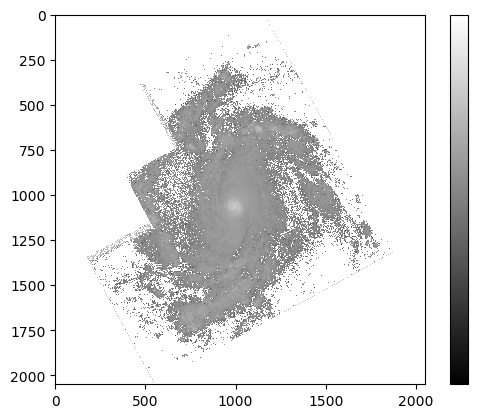

In [11]:
re = display_sia_image(all_results['HLA'], 4)

# Display 2nd GALEX Image

### misgcsn1_13360_0229-nd-int.fits.gz

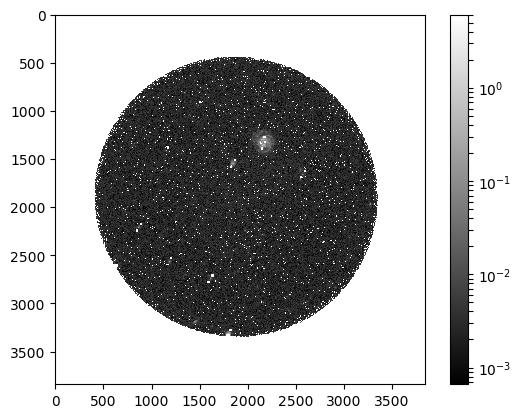

In [12]:
display_sia_image(all_results['GALEX'], 1)